## Bandit Feedback

In the previous notebook we built a purely organic model of user behaviour and used next item prediction to build a recommender system.

We then evaluated how that recommender system performed using IPS.

We also simmulated an AB test.

It is important to recognise that these methods used next item prediction as a proxy for recommendation quality.  Only when we used IPS or an AB test were we actually checking if these recommendations performed well against actual clicks on actual recommendations.

The course now moves to the topic of how to train on actual recommender system logs (rather than a dataset such as movielens that only gives information about user preferences but no measure about if recommendations are successful or otherwise).

The course closely follows the material in this short paper: https://arxiv.org/pdf/1904.10799.pdf


Bandit feedback raises several complications:

1.  Usually we deliver good recommendations if we can, this means that the data is concentrated around good recommendations (as we understand them to be).

2.  There are multiple ways to train on bandit feedback including pure likelihood or Bayesian approaches or approaches that use a counterfactual risk minimisation method that uses the inverse propensity score.  In this notebook we will consider the Likelihood approach.

3.  The support of Bandit feedback is different.  For our click model we have a Bernoulli model for every (counterfactual) action.  In contrast the organic data is a draw from a categorical.  From a practical perspective if there are P products then the bandit data has P parameters between 0 and 1 for a probability of a click where organic data has P parameters that sum to one for the probability of the next item.

4.  Click through rates are usually low and the click through rates for some actions are often very similar therefore we must estimate very low treatment effects.



## Likelihood based models

This notebook will outline the likelihood based approach to training on Bandit feedback.

Although before proceeding we will study the output of the simmulator in a little more detail.

In [26]:
import gym, reco_gym
from copy import deepcopy
from reco_gym import env_1_args
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [6, 3]

ABTestNumberOfUsers=500
NumberOfProducts=10
NumberOfSamples = 20
env_1_args['phi_var']=0.0
env_1_args['number_of_flips']=0
env_1_args['sigma_mu_organic'] = 0.0
env_1_args['sigma_omega']=0
env_1_args['random_seed'] = 42
env_1_args['num_products'] = NumberOfProducts
env_1_args['K'] = 5
env_1_args['number_of_flips'] = 3

env = gym.make('reco-gym-v1')
env.init_gym(env_1_args)

In [27]:
data = deepcopy(env).generate_logs(ABTestNumberOfUsers)

In [28]:
data[:NumberOfSamples]

,a,c,ps,ps-a,t,u,v,z
0,NaN,NaN,NaN,None,0,0,0.0,organic
1,3.0,0.0,0.1,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",1,0,NaN,bandit
2,4.0,0.0,0.1,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",2,0,NaN,bandit
3,5.0,0.0,0.1,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",3,0,NaN,bandit
4,NaN,NaN,NaN,None,0,1,1.0,organic
5,2.0,0.0,0.1,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",1,1,NaN,bandit
6,8.0,0.0,0.1,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",2,1,NaN,bandit
7,4.0,0.0,0.1,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",3,1,NaN,bandit
8,NaN,NaN,NaN,None,4,1,6.0,organic
9,NaN,NaN,NaN,None,5,1,6.0,organic


Here is the data the following columns are present:
* **`t`**—_`Time`_. Currently, _`Time`_ reflects the order of _`Events`_ but it does **not** represent the notion of the time in a physical sense.
* **`u`**—_`User`_.
* **`z`**—_`Event Type`_. There are two types of _`Events`_: _Organic_ and _Bandit_.
* **`v`**—_`View`_. The column shows which _`Product`_ was shown to a _`User`_ in an _Organic_ _`Event`_.
* **`a`**—_`Action`_. Currently, _`Action`_ is a _`Product`_ that was provided to a _`User`_ during a _Bandit_ _`Event`_.
* **`c`**—_`Click`_. This is a _Reward_ for an _`Action`_ provided by the _`Agent`_.
* **`ps`**—Probability of selecting a particular _`Action`_.

**Note #1:** _`Time`_, _`User`_, _`Views`_, and _`Actions`_ **all** them start with _`0`_.

**Note #2:** For any _`User`_, _Organic_ _`Event`_ _**always**_ precedes a _Bandit_ _`Event`_.

## Data Analysis
Let's analyse these histograms:
* _Actions per Product_
* _Clicks per Product_
* _Views per Product_.

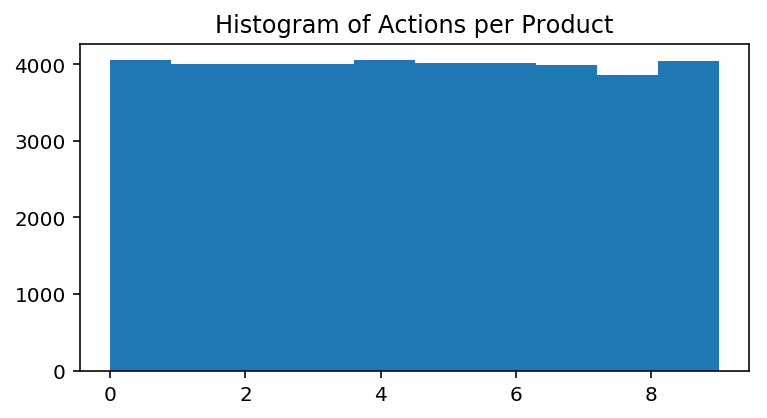

In [29]:
_, ax = plt.subplots()
ax.set_title('Histogram of Actions per Product')

ax.hist(data[data['z'] == 'bandit']['a'])
plt.show()

It is evident that all _`Actions`_ are _*evenly*_ distributed.
That is an expected behaviour because *all* _`Actions`_ are randomly applied for all _Bandit_ _`Events`_.  This is not typical behaviour (usually actions are personalised not random) and we will relax this assumption later in the course.

Clicks:  [40.0, 40.0, 50.0, 43.0, 40.0, 38.0, 31.0, 54.0, 36.0, 44.0]


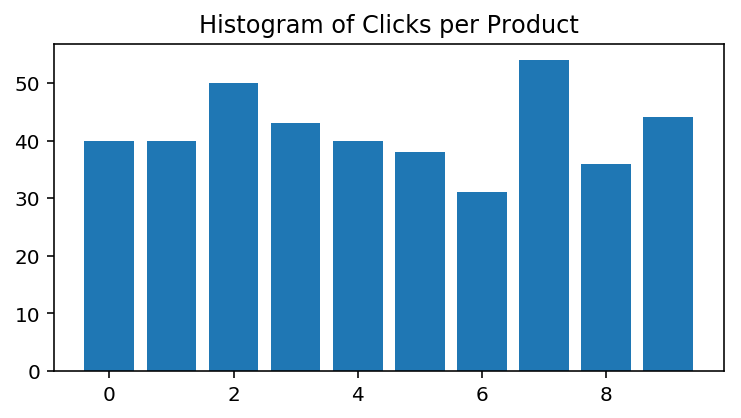

In [30]:
clicks = []
bandits = data[data['z'] == 'bandit']
for product_id in range(NumberOfProducts):
    actions = bandits[bandits['a'] == product_id]
    clicks.append(np.sum(actions[actions['c'] == 1]['c']))
    
print("Clicks: ", clicks)

_, ax = plt.subplots()
ax.set_title('Histogram of Clicks per Product')

ax.bar(range(NumberOfProducts), clicks)
plt.show()

We can estimate a click through rate for each recommendation by dividing the number of times we obtained a click by the number of impressions.  This produces the following "bandit best of":

CTR:  [0.0098668  0.00999001 0.01250625 0.01075    0.0098595  0.00947395
 0.00770952 0.01352705 0.00933126 0.01089648]


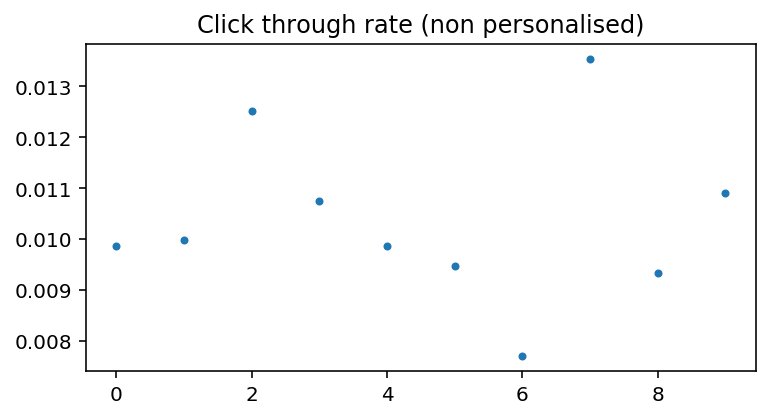

In [31]:
clicks = []
impressions = []
bandits = data[data['z'] == 'bandit']
for product_id in range(NumberOfProducts):
    actions = bandits[bandits['a'] == product_id]
    clicks.append(np.sum(actions[actions['c'] == 1]['c']))
    impressions.append(sum(actions['a']==product_id))

    
    
print("CTR: ", np.array(clicks)/np.array(impressions))

_, ax = plt.subplots()
ax.set_title('Click through rate (non personalised)')

ax.plot(range(NumberOfProducts), np.array(clicks)/np.array(impressions),'.')
plt.show()

The non-personalised click through rate can be uses as a non-personalised agent.  This will be our first likelihood based agent.

FIXME insert bandit best of agent

The ads that in a non-personalised sense attracts the most clicks is not in general the same as a product that is often viewed organically, to see this we can plot the organic views:

Views:  [1546, 986, 1002, 655, 1216, 599, 1310, 1602, 591, 1326]


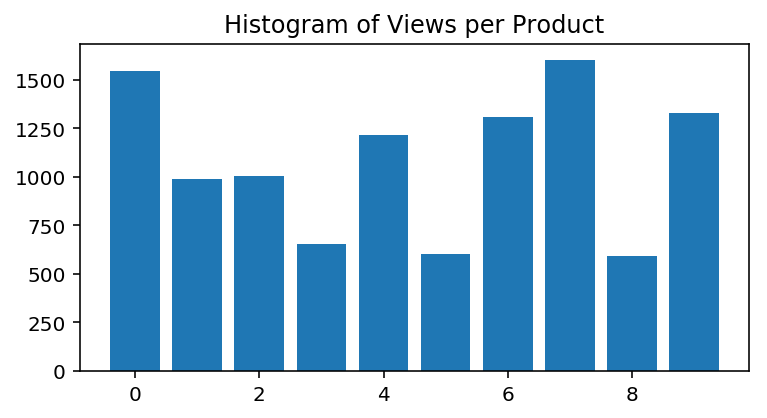

In [32]:
organics = data[data['z'] == 'organic']

views = []
for product_id in range(NumberOfProducts):
    views.append(organics[organics['v'] == product_id].shape[0])

print("Views: ", views)

_, ax = plt.subplots()
ax.set_title('Histogram of Views per Product')

ax.bar(range(NumberOfProducts), views)
plt.show()

While there may be a relationship between popular products and high click through rate it is certainly not guaranteed.  This fact underlies the need to use bandit feedback.  Here we will develop our final organic agent as an organic best of to latter hammer home this point.

TODO organic bestof here

## A more sophisticated bandit feedback agent

# Logistic Regression Model

## Turn Data into Features

Now we are going to build a _Logistic Regression_ model.

The model will predict _the probability of the click_ for the following data:
* _`Views`_ is a total amount of views of a particular _`Product`_ shown during _Organic_ _`Events`_ **before** a _Bandit_ _`Event`_.
* _`Action`_ is a proposed _`Product`_ at a _Bandit_ _`Event`_.

For example, assume that we have _`10`_ products. In _Organic_ _`Events`_, these products  were shown to a user as follows:
<table>
    <tr>
        <th>Product ID</th>
        <th>Views</th>
    </tr>
    <tr>
        <td>0</td>
        <td>0</td>
    </tr>
    <tr>
        <td>1</td>
        <td>0</td>
    </tr>
    <tr>
        <td>2</td>
        <td>0</td>
    </tr>
    <tr>
        <td>3</td>
        <td>7</td>
    </tr>
    <tr>
        <td>4</td>
        <td>0</td>
    </tr>
    <tr>
        <td>5</td>
        <td>0</td>
    </tr>
    <tr>
        <td>6</td>
        <td>0</td>
    </tr>
    <tr>
        <td>7</td>
        <td>8</td>
    </tr>
    <tr>
        <td>8</td>
        <td>11</td>
    </tr>
    <tr>
        <td>9</td>
        <td>0</td>
    </tr>
</table>

When we want to know the probability of the click for _`Product`_ = _`8`_ with available amounts of _`Views`_, the input data for the model will be:

_`0 0 0 7 0 0 0 0 8 11 0`_ _**`8`**_

The first 10 numbers are _`Views`_ of _`Products`_ (see above), the latest one is the _`Action`_.

The output will be two numbers:
* $0^{th}$ index: $1 - \mathbb{P}_c(P=p|V)$.
* $1^{st}$ index: $\mathbb{P}_c(P=p|V)$.

Here, $\mathbb{P}_c(P=p|V)$ is the probability of the click for a _`Product`_ $p$, provided that we have _`Views`_ $V$.


In all following models, an _`Action`_ will not be used as a number, but it will be decoded as a _vector_.
In our current example, the _`Action`_ is _`8`_. Thus, it is encoded as:

_`0 0 0 0 0 0 0 0`_ _**`1`**_ _`0`_

Here,
* Vector of _`Actions`_ has a size that is equal to the _*number of `Products`*_ i.e. _`10`_.
* _`Action`_ _`8`_ is marked as _`1`_ (_`Action`_ starts with _`0`_).

In [33]:
import math
import numpy as np


def build_train_data(
        data,
        mark_action_in_views = False,
        with_normalization = False,
        weight_history_function = None
):
    """
    Build Train Data

        Parameters:
            data: offline experiment logs
                the data contains both Organic and Bandit Events
            mark_action_in_views(bool): adds an extra column into a feature set;
                the column has 1 if in an Action that corresponds to a certain Product
                 has at least one preceding View in Organic Events for the current User
            with_normalization(bool): all Views are normalized to the value in range [0; 1];
            weight_history_function(function): weight functions that assigns an appropriate weight
                for View in Organic Event for a certain Product

        Returns:
            :(features, outs)
    """
    num_products = int(data.v.max() + 1)
    number_of_users = int(data.u.max()) + 1

    features = []
    outs = []

    for user_id in range(number_of_users):
        views = np.zeros((0, num_products))
        for _, user_datum in data[data['u'] == user_id].iterrows():
            if user_datum['z'] == 'organic':
                assert (math.isnan(user_datum['a']))
                assert (math.isnan(user_datum['c']))
                assert (not math.isnan(user_datum['v']))

                view = int(user_datum['v'])

                tmp_view = np.zeros(num_products)

                tmp_view[view] = 1

                # Append the latest view at the beginning of all views.
                views = np.append(tmp_view[np.newaxis, :], views, axis = 0)
            else:
                assert (user_datum['z'] == 'bandit')
                assert (not math.isnan(user_datum['a']))
                assert (not math.isnan(user_datum['c']))
                assert (math.isnan(user_datum['v']))

                action = int(user_datum['a'])
                action_flags = np.zeros(num_products, dtype = np.int8)
                action_flags[int(action)] = 1

                click = int(user_datum['c'])

                if weight_history_function is None:
                    train_views = views
                else:
                    history = np.array(range(views.shape[0])).reshape(views.shape[0], 1)
                    weights = weight_history_function(history)
                    train_views = views * weights

                feature = np.sum(train_views, axis = 0)

                if with_normalization:
                    if np.sum(feature) == 0:
                        feature = feature / np.sum(feature)

                feature = np.append(feature, action_flags)

                if mark_action_in_views:
                    feature = np.append(feature, 0 if feature[action] == 0 else 1)

                features.append(feature)
                outs.append(click)

    return np.array(features), np.array(outs)

In [34]:
train_features01, train_outs01 = build_train_data(data)

The sample of the training data you shall find below.

In [35]:
print("Train Features:\n", train_features01[0:7])
print("Click (Outputs):\n", train_outs01[0:7])

Train Features:
 [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 6. 2. 0. 2. 0. 9. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
Click (Outputs):
 [0 0 0 0 0 0 0]


In [36]:
data[0:27]

,a,c,ps,ps-a,t,u,v,z
0,NaN,NaN,NaN,None,0,0,0.0,organic
1,3.0,0.0,0.1,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",1,0,NaN,bandit
2,4.0,0.0,0.1,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",2,0,NaN,bandit
3,5.0,0.0,0.1,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",3,0,NaN,bandit
4,NaN,NaN,NaN,None,0,1,1.0,organic
5,2.0,0.0,0.1,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",1,1,NaN,bandit
6,8.0,0.0,0.1,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",2,1,NaN,bandit
7,4.0,0.0,0.1,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",3,1,NaN,bandit
8,NaN,NaN,NaN,None,4,1,6.0,organic
9,NaN,NaN,NaN,None,5,1,6.0,organic


The training data contains a record for every bandit event.  The time in the history up until the bandit event is used to build a user profile or context vector.  Here we simply count the number of times each historical product was viewed up until that point in time.  This may loose some valuable information, the time and the sequence of the views is lost, but it seems like a reasoanble summary to make to produce a fixed dimensional user vector (which is required by many machine learning methods).

This is called the feature engineering approach to producing a user embedding, modelling approaches can also be employed: e.g. see: https://arxiv.org/abs/1904.10784